In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 protobuf==4.25.3 mediapipe==0.10.20 opencv-python-headless matplotlib pillow --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import cv2
import mediapipe as mp
import numpy as np
from math import atan2, degrees
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose

def classify_posture(landmarks, img_w, img_h):
    try:
        left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
        right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
        nose = landmarks[mp_pose.PoseLandmark.NOSE]
    except:
        return "Not detected (insufficient keypoints)", 0

    mid_sh_x = (left_shoulder.x + right_shoulder.x) / 2 * img_w
    mid_sh_y = (left_shoulder.y + right_shoulder.y) / 2 * img_h
    mid_hp_x = (left_hip.x + right_hip.x) / 2 * img_w
    mid_hp_y = (left_hip.y + right_hip.y) / 2 * img_h

    dx = mid_hp_x - mid_sh_x
    dy = mid_hp_y - mid_sh_y
    angle_deg = abs(degrees(atan2(dx, dy)))
    torso_length = np.hypot(dx, dy)
    torso_ratio = torso_length / img_h

    # If torso angle is high and torso length significant, person might be lying down or sleeping
    if angle_deg > 50 and torso_ratio > 0.15:
        # Check nose vertical position relative to shoulders to guess sleeping
        if nose.y * img_h > mid_sh_y + 40:
            return "Sleeping", 0.95
        return "Lying down", 0.92
    else:
        hip_y_norm = mid_hp_y / img_h
        if hip_y_norm > 0.62:
            return "Sitting", 0.90
        else:
            return "Standing", 0.93

def display_image_with_text(bgr_img, text, confidence, title=""):
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.title(f"{title}\n{text} ({confidence*100:.1f}% confidence)", fontsize=14)
    plt.show()

def process_image_bytes(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = np.array(image)[:, :, ::-1].copy()  # Convert RGB to BGR for OpenCV
    height, width = img.shape[:2]

    # Show original image first
    display_image_with_text(img, "Original Image", 1.0, title="Before Processing")

    with mp_pose.Pose(static_image_mode=True, model_complexity=1) as pose:
        results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            display_image_with_text(img, "No body detected", 0)
            return

        landmarks = {i: l for i, l in enumerate(results.pose_landmarks.landmark)}
        landmarks_map = {mp_pose.PoseLandmark(i): landmarks[i] for i in landmarks}
        label, confidence = classify_posture(landmarks_map, width, height)

        annotated_img = img.copy()
        mp.solutions.drawing_utils.draw_landmarks(annotated_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Show annotated image with posture label and confidence
        display_image_with_text(annotated_img, label, confidence, title="After Processing")

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.7.0, so it will not be used.
  warnings.warn(


Upload 2 image files


Saving istockphoto-847905010-612x612.jpg to istockphoto-847905010-612x612 (1).jpg
Saving istockphoto-1288961992-612x612.jpg to istockphoto-1288961992-612x612 (1).jpg


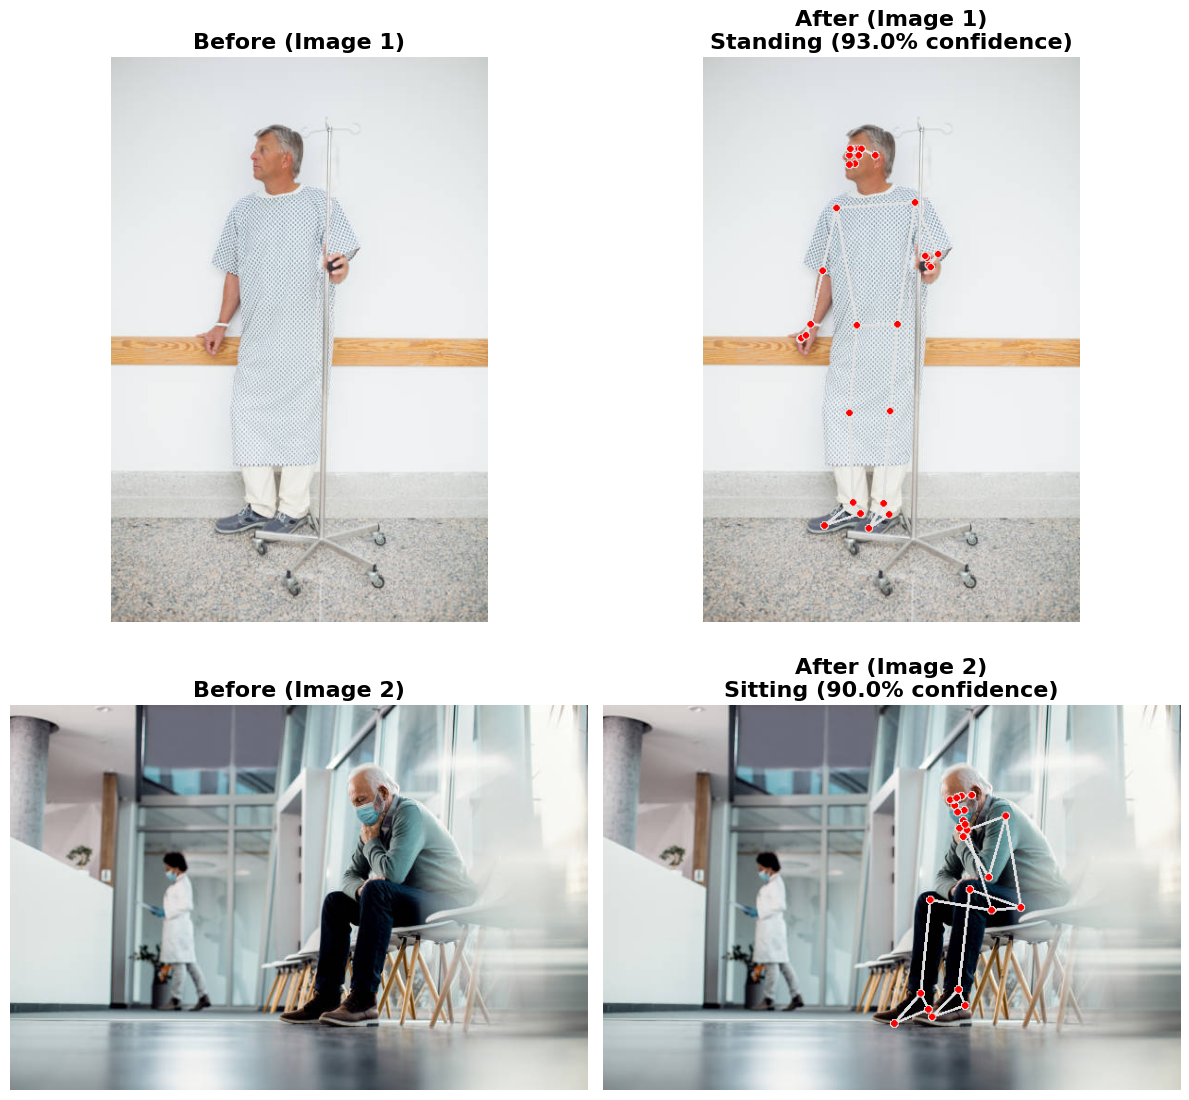

In [6]:
import cv2
import mediapipe as mp
import numpy as np
from math import atan2, degrees
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    a = np.array([a.x, a.y])
    b = np.array([b.x, b.y])
    c = np.array([c.x, c.y])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def classify_posture(landmarks, img_w, img_h):
    try:
        l_sh = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
        r_sh = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        l_hp = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
        r_hp = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
        l_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
        r_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
        l_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]
        r_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]
        nose = landmarks[mp_pose.PoseLandmark.NOSE]
    except:
        return "Not detected", 0

    mid_sh_x = (l_sh.x + r_sh.x) / 2 * img_w
    mid_sh_y = (l_sh.y + r_sh.y) / 2 * img_h
    mid_hp_x = (l_hp.x + r_hp.x) / 2 * img_w
    mid_hp_y = (l_hp.y + r_hp.y) / 2 * img_h

    dx = mid_hp_x - mid_sh_x
    dy = mid_hp_y - mid_sh_y
    angle_deg = abs(degrees(atan2(dx, dy)))
    torso_length = np.hypot(dx, dy)
    torso_ratio = torso_length / img_h

    left_knee_angle = calculate_angle(l_hp, l_knee, l_ankle)
    right_knee_angle = calculate_angle(r_hp, r_knee, r_ankle)
    avg_knee_angle = (left_knee_angle + right_knee_angle) / 2

    if angle_deg > 50 and torso_ratio > 0.15:
        if nose.y * img_h > mid_sh_y + 40:
            return "Sleeping", 0.95
        return "Lying down", 0.92

    if avg_knee_angle < 140:
        return "Sitting", 0.90

    return "Standing", 0.93

def process_image_bytes(image_bytes):
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = np.array(image)[:, :, ::-1].copy()  # RGB to BGR
    height, width = img.shape[:2]

    with mp_pose.Pose(static_image_mode=True, model_complexity=1) as pose:
        results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            return img, img, "No body detected", 0

        landmarks = {i: l for i, l in enumerate(results.pose_landmarks.landmark)}
        landmarks_map = {mp_pose.PoseLandmark(i): landmarks[i] for i in landmarks}
        label, confidence = classify_posture(landmarks_map, width, height)

        annotated_img = img.copy()
        mp.solutions.drawing_utils.draw_landmarks(annotated_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    return img, annotated_img, label, confidence

# --- Upload 2 images ---
print("Upload 2 image files")
uploaded_files = files.upload()
images_data = [uploaded_files[fn] for fn in uploaded_files if fn.lower().endswith(('.png', '.jpg', '.jpeg'))]

if len(images_data) != 2:
    print("Please upload exactly 2 images.")
else:
    results = [process_image_bytes(img_bytes) for img_bytes in images_data]

    # Display academic-style table
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for i, (original, annotated, label, conf) in enumerate(results):
        axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Before (Image {i+1})", fontsize=16, fontweight='bold')

        axes[i, 1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"After (Image {i+1})\n{label} ({conf*100:.1f}% confidence)", fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [7]:
import cv2
from google.colab import files

# Upload the image
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Read the image
img = cv2.imread(filename)

# Resize to 4K resolution (3840x2160)
img_4k = cv2.resize(img, (3840, 2160), interpolation=cv2.INTER_CUBIC)

# Save the 4K image
output_filename = "image_4k.png"
cv2.imwrite(output_filename, img_4k)

print(f"4K image saved as {output_filename}")


Saving download.png to download.png
4K image saved as image_4k.png


In [5]:
import cv2
import mediapipe as mp
import numpy as np
from math import atan2, degrees
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt
from IPython.display import display, Video

mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    a = np.array([a.x, a.y])
    b = np.array([b.x, b.y])
    c = np.array([c.x, c.y])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def classify_posture(landmarks, img_w, img_h):
    try:
        l_sh = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
        r_sh = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        l_hp = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
        r_hp = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
        l_knee = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
        r_knee = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
        l_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]
        r_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]
        nose = landmarks[mp_pose.PoseLandmark.NOSE]
    except:
        return "Not detected", 0

    mid_sh_x = (l_sh.x + r_sh.x) / 2 * img_w
    mid_sh_y = (l_sh.y + r_sh.y) / 2 * img_h
    mid_hp_x = (l_hp.x + r_hp.x) / 2 * img_w
    mid_hp_y = (l_hp.y + r_hp.y) / 2 * img_h

    dx = mid_hp_x - mid_sh_x
    dy = mid_hp_y - mid_sh_y
    angle_deg = abs(degrees(atan2(dx, dy)))
    torso_length = np.hypot(dx, dy)
    torso_ratio = torso_length / img_h

    left_knee_angle = calculate_angle(l_hp, l_knee, l_ankle)
    right_knee_angle = calculate_angle(r_hp, r_knee, r_ankle)
    avg_knee_angle = (left_knee_angle + right_knee_angle) / 2

    if angle_deg > 50 and torso_ratio > 0.15:
        if nose.y * img_h > mid_sh_y + 40:
            return "Sleeping", 0.95
        return "Lying down", 0.92

    if avg_knee_angle < 140:
        return "Sitting", 0.90

    return "Standing", 0.93

def process_video_bytes(video_bytes, output_filename='output.mp4'):
    # Save input video bytes
    with open('input_video.mp4', 'wb') as f:
        f.write(video_bytes)

    cap = cv2.VideoCapture('input_video.mp4')

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS) or 15
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    with mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.5) as pose:
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)

            if results.pose_landmarks:
                lm = {i: l for i, l in enumerate(results.pose_landmarks.landmark)}
                landmarks_map = {mp_pose.PoseLandmark(i): lm[i] for i in lm}
                label, conf = classify_posture(landmarks_map, width, height)
                # Draw landmarks
                mp.solutions.drawing_utils.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                # Put text label and confidence on frame
                cv2.putText(frame, f"{label} ({conf*100:.1f}%)", (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            else:
                cv2.putText(frame, "No body detected", (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

            out.write(frame)
            frame_count += 1

    cap.release()
    out.release()

    print(f"Processed {frame_count} frames.")
    return output_filename

# Upload and process video
print("Upload a video file")
uploaded = files.upload()

for fname in uploaded:
    if fname.lower().endswith(('.mp4', '.mov', '.avi', '.mkv')):
        print(f"Processing video: {fname}")
        output_path = process_video_bytes(uploaded[fname])
        print("Displaying processed video:")
        display(Video(output_path))
    else:
        print(f"Unsupported file type: {fname}. Please upload a video.")

Upload a video file


Saving istockphoto-847905010-612x612.jpg to istockphoto-847905010-612x612.jpg
Unsupported file type: istockphoto-847905010-612x612.jpg. Please upload a video.
